In [17]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve
from sklearn.preprocessing import Imputer
import statsmodels.api as sm
from scipy.interpolate import interp1d, interp2d

In [5]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Get Data

In [30]:
with pd.HDFStore('../data/data.h5') as store:
    data = store['engineered_features']

    data = (data
            .drop([c for c in data.columns if c.startswith('target') 
                      and not c.startswith('target_1m')], axis=1)
            .rename(columns={'target_1m': 'returns'})
            .dropna())
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 431221 entries, (A, 2001-07-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 29 columns):
return_1m        431221 non-null float64
return_2m        431221 non-null float64
return_3m        431221 non-null float64
return_6m        431221 non-null float64
return_9m        431221 non-null float64
return_12m       431221 non-null float64
CMA              431221 non-null float64
HML              431221 non-null float64
Mkt-RF           431221 non-null float64
RMW              431221 non-null float64
SMB              431221 non-null float64
momentum_2       431221 non-null float64
momentum_3       431221 non-null float64
momentum_6       431221 non-null float64
momentum_9       431221 non-null float64
momentum_12      431221 non-null float64
momentum_3_12    431221 non-null float64
year             431221 non-null int64
month            431221 non-null int64
return_1m_t-1    431221 non-null float64
return_1m_t-2    431221 non-n

### Generate dummy data

In [36]:
dummy_data = (pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
              .pipe(lambda x: x.rename(columns={c:c.replace('.0', '') for c in x.columns})))
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 431221 entries, (A, 2001-07-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 85 columns):
return_1m                431221 non-null float64
return_2m                431221 non-null float64
return_3m                431221 non-null float64
return_6m                431221 non-null float64
return_9m                431221 non-null float64
return_12m               431221 non-null float64
CMA                      431221 non-null float64
HML                      431221 non-null float64
Mkt-RF                   431221 non-null float64
RMW                      431221 non-null float64
SMB                      431221 non-null float64
momentum_2               431221 non-null float64
momentum_3               431221 non-null float64
momentum_6               431221 non-null float64
momentum_9               431221 non-null float64
momentum_12              431221 non-null float64
momentum_3_12            431221 non-null float64
return_1m_t-

### Stock Prices

In [37]:
y = data.returns
X = data.drop('returns', axis=1)

### Binary Outcome

In [38]:
y_binary = (y>0).astype(int)

### 2 Lags Only

In [39]:
X2 = X.loc[:, ['return_1m_t-1', 'return_1m_t-2']]
X2.columns = ['t-1', 't-2']
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 431221 entries, (A, 2001-07-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 2 columns):
return_1m_t-1    431221 non-null float64
return_1m_t-2    431221 non-null float64
dtypes: float64(2)
memory usage: 8.3+ MB


## Explore Data

In [40]:
y.describe(percentiles=np.arange(.1, .91, .1))

count    431221.000000
mean          0.011678
std           0.117853
min          -0.346734
10%          -0.118016
20%          -0.065091
30.0%        -0.034006
40%          -0.010690
50%           0.009015
60%           0.029351
70%           0.052545
80%           0.083434
90%           0.139514
max           0.455373
Name: returns, dtype: float64

## Custom KFold

In [41]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, chunk_size):
        for i in range(0, len(l), chunk_size):
            yield l[i:i + chunk_size]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)[:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [42]:
def regression_benchmark():
    rmse = []
    for train_idx, test_idx in cv.split(X):
        mean = y.iloc[train_idx].mean()
        data = y.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        rmse.append(np.sqrt(mean_squared_error(data.y_test, data.y_pred))) 
    return np.mean(rmse)

In [43]:
def classification_benchmark():
    auc = []
    for train_idx, test_idx in cv.split(X):
        mean = y_binary.iloc[train_idx].mean()
        data = y_binary.iloc[test_idx].to_frame('y_test').assign(y_pred=mean)
        auc.append(roc_auc_score(data.y_test, data.y_pred))
    return np.mean(auc)

## Simple Regression Tree

### Configure Tree

In [44]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=4,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    presort=False)

### Train Decision Tree

In [45]:
%%timeit
reg_tree_t2.fit(X=X2, y=y)

523 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
reg_tree_t2.fit(X=X2, y=y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

### Visualize Tree

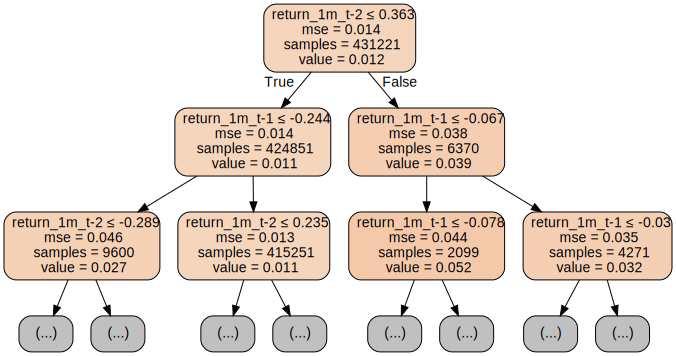

In [47]:
out_file = 'figures/reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file,
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

#### statsmodels OLS

In [48]:
%%timeit
ols_model = sm.OLS(endog=y_binary, exog=sm.add_constant(X2)).fit()

80.7 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
ols_model = sm.OLS(endog=y, exog=sm.add_constant(X2)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     64.06
Date:                Wed, 31 Oct 2018   Prob (F-statistic):           1.53e-28
Time:                        18:06:45   Log-Likelihood:             3.1028e+05
No. Observations:              431221   AIC:                        -6.205e+05
Df Residuals:                  431218   BIC:                        -6.205e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0116      0.000     63.828

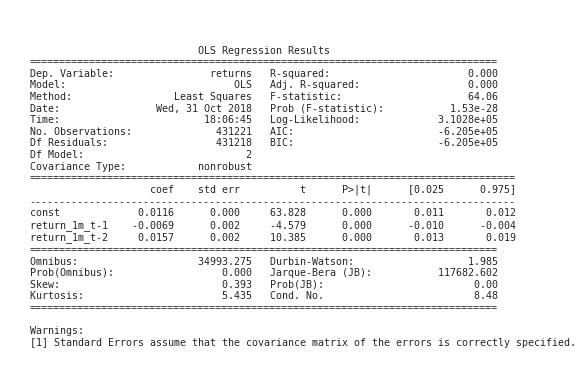

In [50]:
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(ols_model.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('/home/stefan/Dropbox/Data Science/AI & ML/Algorithmic Trading/09 Decision Trees & Random Forests/Figures/ols_summary.png', bbox_inches='tight', dpi=300);

#### statsmodels AR(2) Model

Coefficients slighty different because AR model treats returns as a single time series instead creating groups by ticker.

In [51]:
%%timeit
sm.tsa.ARMA(endog=y, order=(2,0)).fit()

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different r

4.95 s ± 264 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
ar_model = sm.tsa.ARMA(endog=y, order=(2,0)).fit()

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different r

In [53]:
pd.DataFrame({'AR(2)': ar_model.params.values, 
              'OLS': ols_model.params.values}, 
             index=ols_model.params.index)

,AR(2),OLS
const,0.011678,0.011571
return_1m_t-1,0.007714,-0.006948
return_1m_t-2,-0.006976,0.015726


In [54]:
ar_preds = ar_model.predict()

#### ARMA(2,2)

In [55]:
%%timeit
sm.tsa.ARMA(endog=y, order=(2, 2)).fit()

/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/stefan/.pyenv/versions/at-3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: 

In [ ]:
arma_model = sm.tsa.ARMA(endog=y, order=(2, 2)).fit()
print(arma_model.summary())

In [ ]:
arma_preds = arma_model.predict()

In [ ]:
preds = X2.assign(arma=arma_preds, ar=ar_preds).sample(frac=.1).sort_values(['t-1', 't-2'])
preds.info()

In [ ]:
q = 20
preds['t-1q'] = pd.qcut(preds['t-1'], q=q, labels=list(range(1, q+1))).astype(int)
preds['t-2q'] = pd.qcut(preds['t-2'], q=q, labels=list(range(1, q+1))).astype(int)

In [ ]:
q = 20
preds['t-1q'] = pd.qcut(preds['t-1'], q=q)
preds['t-2q'] = pd.qcut(preds['t-2'], q=q)

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.heatmap(preds.groupby(['t-1q', 't-2q']).ar.median().unstack(), ax=axes[0], cmap='BuPu_r')
axes[0].set_title('AR(2) Model')
sns.heatmap(preds.groupby(['t-1q', 't-2q']).arma.median().unstack(), ax=axes[1], cmap='BuPu_r')
axes[1].set_title('ARMA(2,2) Model')
fig.tight_layout();

### sklearn Linear Regression

In [ ]:
lin_reg = LinearRegression()

In [ ]:
%%timeit
lin_reg.fit(X=X2,y=y)

In [ ]:
lin_reg.intercept_

In [ ]:
lin_reg.coef_

### Plot Decision Surfaces

In [ ]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].min(), X2['t-1'].max(), 1000),
                     np.linspace(X2['t-2'].min(), X2['t-2'].max(), 1000))
X_data = np.c_[t1.ravel(), t2.ravel()]

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = regression_tree.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree

### Loss Functions

In [ ]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

In [ ]:
def gini(f):
    return 2*f*(1-f)

In [ ]:
def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2));

#### Compare computation time

In [ ]:
%%timeit
misclassification_rate(x)

In [ ]:
%%timeit
gini(x)

In [ ]:
%%timeit
entropy(x)

### Configure Tree

In [ ]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=4,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None,
                                     presort=False)

### Train Tree

In [ ]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

In [ ]:
clf_tree_t2.fit(X=X2, y=y_binary)

### Visualize Tree

In [ ]:
out_file = 'figures/clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file,
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Logistic Regression

#### Statsmodels

In [ ]:
%%timeit
sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit(disp=0)

In [ ]:
model = sm.Logit(endog=y_binary, exog=sm.add_constant(X2)).fit()
print(model.summary())

#### sklearn

In [ ]:
logistic_reg = LogisticRegression()

In [ ]:
%%timeit
logistic_reg.fit(X=X2, y=y_binary)

In [ ]:
logistic_reg.coef_

### Plot Decision Surfaces

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = logistic_reg.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = classifier.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Print Decision Path

Inspired by https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

In [ ]:
from sklearn.tree._tree import Tree
help(Tree)

In [ ]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [ ]:
tree_to_code(classifier, X2.columns)

## Classification Tree with all Features

### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [ ]:
clf.fit(X=X_train, y=y_train)

In [ ]:
y_score = clf.predict_proba(X=X_test)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_test)

### Plot Tree

In [ ]:
out_file = 'figures/clf_tree.dot'
dot_data = export_graphviz(clf,
                           out_file=out_file,
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [ ]:
y_pred = classifier.predict_proba(X_test)[:, 1]

In [ ]:
roc_auc_score(y_true=y_test, y_score=y_pred)

## Regression Tree with all Features

### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Configure Tree

In [ ]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

### Train Model

In [ ]:
regression_tree.fit(X=X_train, y=y_train)

### Visualize Tree

In [ ]:
out_file = 'figures/reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file,
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [ ]:
y_pred = regression_tree.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

## Parameter Tuning

Cross-validate key parameters

In [ ]:
def plot_cv_results(cv_scores, metric='AUC', parameter='Max. Depth'):
    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(cv_scores)
    sns.tsplot(df.values, time=df.columns, ax=ax, lw=2)
    ax.set_title(f'{len(df)}-Fold Cross-Validation Result')
    ax.set_xlabel(parameter)
    ax.set_ylabel(metric)
    if metric == 'AUC':
        ax.axvline(df.mean().idxmax(), ls='--', c='k', lw=1);
        ax.axhline(classification_benchmark(), c='red', lw=1, ls='--') 
    else:
        ax.axvline(df.mean().idxmin(), ls='--', c='k', lw=1);
        ax.axhline(regression_benchmark(), c='red', lw=1, ls='--')

### Classifier

### Cross-Validation Score

In [ ]:
cv = OneStepTimeSeriesSplit(n_splits=10)

In [ ]:
clf_results = {}
for max_depth in range(1, 26):
    clf_tree = DecisionTreeClassifier(criterion='gini',
                                      max_depth=max_depth,
                                      min_samples_leaf=5,
                                      random_state=42)
    clf_results[max_depth] = cross_val_score(clf_tree,
                                             X=X,
                                             y=y_binary,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             cv=cv)

In [ ]:
plot_cv_results(clf_results)

### Train-Test Result

In [ ]:
max_depths = range(1, 26)

In [ ]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

In [ ]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=500,
                                 max_features='auto',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)    
        leaves[max_depth].append(get_leaves_count(clf))
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

## Regression Tree

### Cross-Validation Scores

In [ ]:
reg_results = {}
for max_depth in range(1, 26):
    reg_tree = DecisionTreeRegressor(criterion='mse',
                                     max_depth=max_depth,
                                     min_samples_leaf=500,
                                     random_state=42)
    reg_results[max_depth] = np.sqrt(-cross_val_score(reg_tree,
                                             X=X,
                                             y=y,
                                             scoring='neg_mean_squared_error',
                                             n_jobs=-1,
                                             cv=cv))

In [ ]:
plot_cv_results(reg_results, metric='RMSE')

In [ ]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=500,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = np.sqrt(mean_squared_error(
            y_pred=train_pred, y_true=y_train))
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = np.sqrt(mean_squared_error(
            y_pred=test_pred, y_true=y_test))
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

#### Plot Results

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
time = pd.Series(max_depths, name='Max. Depth')
sns.tsplot(data=np.dstack((reg_train_scores, reg_valid_scores)),
           time=time,
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[0],
           lw=2)
ax0 = axes[0].twinx()
sns.tsplot(data=reg_leaves.values, time=time, ax=ax0, ls='--', lw=1, color='k')
ax0.set_yscale('log', basey=2)
ax0.grid(None)
ax0.set_ylabel('# Leaf Nodes')
axes[0].set_title('Regression Tree')
axes[0].set_ylabel('RMSE')
axes[0].yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].axvline(x=reg_valid_scores.mean().idxmin(), ls='--', c='k', lw=1)
axes[0].axhline(y=regression_benchmark(), ls='-', c='k', lw=1)


sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=['Train', 'Valid'],
           ci=95,
           ax=axes[1],
           lw=2)
ax1 = axes[1].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[1].set_title('Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=classification_benchmark(), ls='-', c='k', lw=1)

fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)

### GridSearch

#### Classification Tree

In [ ]:
OneStepTimeSeriesSplit

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
param_grid = {'max_depth': range(10, 20),
              'min_samples_leaf': [250, 500, 750],
              'max_features': ['sqrt', 'auto']
              }

In [ ]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

In [ ]:
gridsearch_clf.fit(X=X, y=y_binary)

In [ ]:
gridsearch_clf.best_params_

In [ ]:
gridsearch_clf.best_score_

#### Regression Tree

In [ ]:
reg_tree = DecisionTreeRegressor(random_state=42)

param_grid = {'max_depth': [1,2],
              'min_samples_leaf': [10],
              'max_features': [None, 'sqrt']
              }

In [ ]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [ ]:
gridsearch_reg.fit(X=X, y=y)

In [ ]:
gridsearch_reg.best_params_

In [ ]:
np.sqrt(-gridsearch_reg.best_score_)

In [ ]:
regression_benchmark()

### Learning Curves

#### Classifier

In [ ]:
sizes = np.arange(.1, 1.01, .1)

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                          X,
                                                          y_binary,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='roc_auc',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
clf_data = np.dstack((train_scores.T, valid_scores.T))

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
condition = ['Training', 'Validation']
sns.tsplot(data=np.dstack((clf_train_scores, clf_valid_scores)),
           time=pd.Series(max_depths, name='Max. Depth'),
           condition=condition,
           ci=95,
           ax=axes[0],
           lw=2)
ax1 = axes[0].twinx()
sns.tsplot(data=clf_leaves.values, time=time, ax=ax1, ls='--', lw=1, color='k')
ax1.set_yscale('log', basey=2)
ax1.grid(None)
axes[0].set_title('Cross-Validation Results')
axes[0].set_ylabel('ROC AUC')
axes[0].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)


sns.tsplot(data=clf_data, 
           time=pd.Series(train_sizes, name='Train Size'), 
           condition=condition, 
           ci=95, 
           ax=axes[1],
          lw=2)
axes[1].set_title('Learning Curve')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


# fig.suptitle(f'Train-Validation Scores', fontsize=18)
fig.tight_layout()
# fig.subplots_adjust(top=.9)

#### Regression Tree

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                          X, y,
                                                          train_sizes=sizes,
                                                          cv=cv,
                                                          scoring='neg_mean_squared_error',
                                                          n_jobs=-1,
                                                          shuffle=True,
                                                          random_state=42)
reg_data = np.dstack((train_scores.T, valid_scores.T))

#### Plot Result

In [ ]:
time = pd.Series(train_sizes, name='Train Size')

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
sns.tsplot(data=clf_data, 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[0],
          lw=2)
axes[0].set_title('Best Classification Tree')
axes[0].set_ylabel('ROC AUC')
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.tsplot(data=np.sqrt(-reg_data), 
           time=time, 
           condition=['Train', 'Valid'], 
           ci=95, 
           ax=axes[1],
           lw=2)
axes[1].set_title('Best Regression Tree')
axes[1].set_ylabel('RMSE')
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
fig.suptitle('Learning Curves', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9);

### Feature Importance

In [ ]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

In [ ]:
fig, axes= plt.subplots(ncols=2, figsize=(12,6))
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[0], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[1], title='Regression Tree', color=color)
fig.suptitle(f'Top {top_n} Feature Importances', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9);

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, ax=axes[0], ylim=(0, .55)))

top_n = 15
labels = X.columns.str.replace('_', ' ').str.capitalize()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Feature Importances', color=color)


# fig.suptitle('Best Classification Tree', fontsize=20)
fig.tight_layout()
# fig.subplots_adjust(top=.9);

In [ ]:
dt = pd.DataFrame({'y': [1,2,3], 'x': [2, np.nan, 3]})
dt